In [16]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)
data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']]
y = data['closePrice']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = CatBoostRegressor(
    iterations=1000,
    depth=10,
    learning_rate=0.01,
    loss_function='RMSE',
    eval_metric='RMSE',
    early_stopping_rounds=50,
    verbose=200,
    random_seed=42
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    verbose=200
)

0:	learn: 17387.2973039	test: 8169.6226046	best: 8169.6226046 (0)	total: 8.74ms	remaining: 8.74s
200:	learn: 3024.7797153	test: 2839.7870854	best: 2839.7870854 (200)	total: 1.72s	remaining: 6.82s
400:	learn: 1263.2747296	test: 2434.2753565	best: 2434.2753565 (400)	total: 3.42s	remaining: 5.11s
600:	learn: 1023.1319990	test: 2415.7490285	best: 2414.8732152 (579)	total: 5.15s	remaining: 3.42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2414.696761
bestIteration = 613

Shrink model to first 614 iterations.


In [20]:
evals_result = model.evals_result_
iterations = range(1, len(evals_result['learn']['RMSE']) + 1)

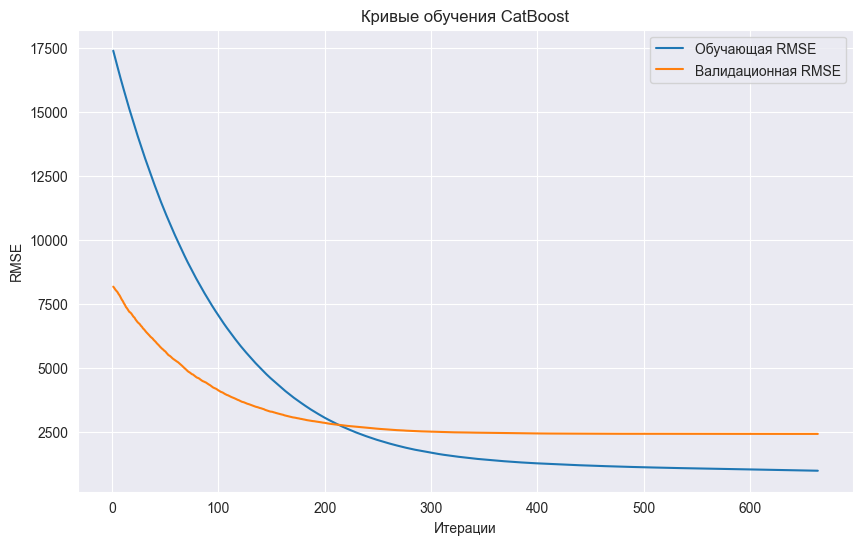

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, evals_result['learn']['RMSE'], label='Обучающая RMSE')
plt.plot(iterations, evals_result['validation']['RMSE'], label='Валидационная RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.title('Кривые обучения CatBoost')
plt.xlabel('Итерации')
plt.grid(True)
plt.show()

In [22]:
y_pred = model.predict(X_test)

In [23]:
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE): {mse}')

Среднеквадратичная ошибка (MSE): 5830760.449270761


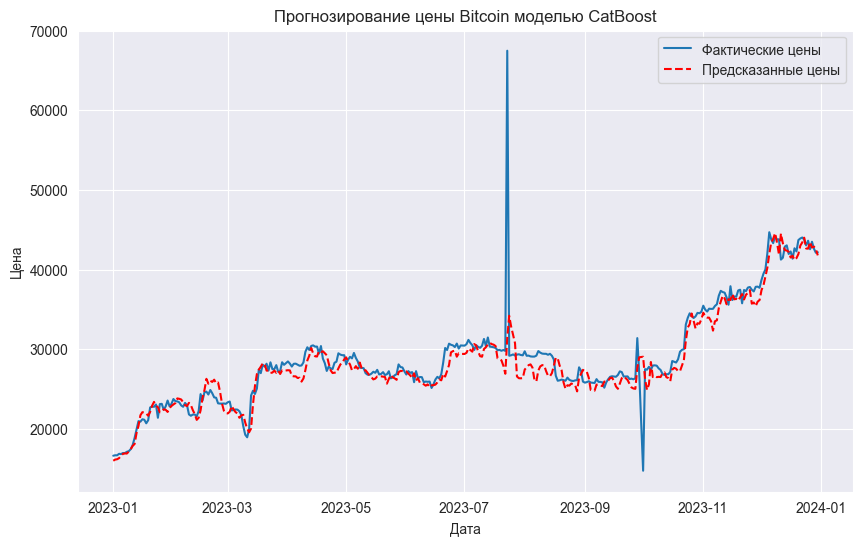

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Фактические цены')
plt.plot(y_test.index, y_pred, label='Предсказанные цены', linestyle='--', color='red')
plt.legend()
plt.title('Прогнозирование цены Bitcoin моделью CatBoost')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True)
plt.show()